# Importing necessary libraries


In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
dataset = pd.read_csv("/content/drive/MyDrive/dataset/IMDB Dataset.csv/IMDB Dataset.csv")
negative = len(dataset[dataset['sentiment']=='negative'])
positive = len(dataset) - negative
print('Positive reviews are {} and negative reviews are {} of total {} '.format(positive,negative,len(dataset)))

Positive reviews are 25000 and negative reviews are 25000 of total 50000 


In [28]:
import re
#clearing punctuation & unnecessary marks
dataset['review'] = dataset['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
dataset['review'] = dataset['review'].apply(lambda x: re.sub('[^a-zA-Z"]', ' ', x))

#capitalization to lowercase
dataset['review'] = dataset['review'].apply(lambda x: x.lower())

#cleaning extra spaces
dataset['review'] = dataset['review'].apply(lambda x: x.strip())

In [29]:
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK stopwords data
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text()

    # Remove non-alphanumeric characters
    clean_text = re.sub(r'[^a-zA-Z\s]', '', clean_text)

    # Convert to lowercase
    clean_text = clean_text.lower()

    # Remove stopwords
    word_tokens = word_tokenize(clean_text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

    # Join the words back into a string
    cleaned_text = ' '.join(filtered_text)

    return cleaned_text


dataset['review'] = dataset['review'].apply(preprocess_text)
print(dataset['review'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0        one reviewers mentioned watching oz episode ho...
1        wonderful little production br br filming tech...
2        thought wonderful way spend time hot summer we...
3        basically family little boy jake thinks zombie...
4        petter mattei love time money visually stunnin...
                               ...                        
49995    thought movie right good job creative original...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    going disagree previous comment side maltin on...
49999    one expects star trek movies high art fans exp...
Name: review, Length: 50000, dtype: object


Converting the labels positve and negative as 1,0 so that they can be fed to the neural network to predict whether the given review is a positive or negative. Splitting of data 80% for the training and remaining 20% for testing.

In [30]:
le = LabelEncoder()
training_reviews,testing_reviews,training_labels,testing_labels  = train_test_split(dataset['review'].values,dataset['sentiment'].values,test_size = 0.2)
training_labels = le.fit_transform(training_labels)
testing_labels = le.fit_transform(testing_labels)

# Pre-Processing The Text
Using tokenizer to produce token for a given word and taking maximum length of 200 character of a review and after we simply truncate the input review and then padded the input to max len of 200.

In [31]:
tokenizer = Tokenizer(num_words=10000,oov_token='<OOV>')
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_reviews)
testing_sequence = tokenizer.texts_to_sequences(testing_reviews)
train_pad_sequence = pad_sequences(training_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
test_pad_sequence = pad_sequences(testing_sequence,maxlen = 200,truncating= 'post',padding = 'pre')
print('Total Unique Words : {}'.format(len(word_index)))

Total Unique Words : 109747


# Using glove vectors for embedding

In [32]:
embedded_words = {}
with open('/content/drive/MyDrive/glove tonkenizer/glove.6B.200d.txt/glove.6B.200d.txt') as file:
    for line in file:
        words, coeff = line.split(maxsplit=1)
        coeff = np.array(coeff.split(),dtype = float)
        embedded_words[words] = coeff

In [33]:
embedding_matrix = np.zeros((len(word_index) + 1,200))
for word, i in word_index.items():
    embedding_vector = embedded_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Creating The Model
layer1: Embedding Layer using glove weights

layer2: Using a Bidirectional LSTM

layer3: A dropout Layer

layer4: A Dense layer of 256 neurons with 'relu' activation

layer5: A Dense Layer of 128 neurons with 'relu' activation

layer6: Again a dropout layer.

layer7: Sigmoid activation layer to classify it positive and negative.


In [34]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(len(word_index) + 1,200,weights=[embedding_matrix],input_length=200,
                            trainable=False),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.8),
                             tf.keras.layers.Dense(256,activation = 'relu',),
                             tf.keras.layers.Dense(128,activation = 'relu'),
                             tf.keras.layers.Dropout(0.8),
                             tf.keras.layers.Dense(1,activation = tf.nn.sigmoid)])
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          21949600  
                                                                 
 bidirectional (Bidirection  (None, 128)               135680    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [37]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy() , optimizer='Adam' , metrics = 'accuracy')
history = model.fit(train_pad_sequence,training_labels,epochs = 10, validation_data=(test_pad_sequence,testing_labels),
                   callbacks=[mcp_save])

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 0.4183 - accuracy: 0.8249

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1250/1250 [==============================] - 481s 379ms/step - loss: 0.4183 - accuracy: 0.8249 - val_loss: 0.3671 - val_accuracy: 0.8446
Epoch 2/10
1250/1250 [==============================] - 505s 404ms/step - loss: 0.3722 - accuracy: 0.8482 - val_loss: 0.3251 - val_accuracy: 0.8660
Epoch 3/10
1250/1250 [==============================] - 482s 386ms/step - loss: 0.3391 - accuracy: 0.8626 - val_loss: 0.3096 - val_accuracy: 0.8683
Epoch 4/10
1250/1250 [==============================] - 507s 406ms/step - loss: 0.3182 - accuracy: 0.8735 - val_loss: 0.2957 - val_accuracy: 0.8773
Epoch 5/10
1250/1250 [==============================] - 469s 375ms/step - loss: 0.2998 - accuracy: 0.8824 - val_loss: 0.2990 - val_accuracy: 0.8798
Epoch 6/10
1250/1250 [==============================] - 515s 412ms/step - loss: 0.2875 - accuracy: 0.8877 - val_loss: 0.2982 - val_accuracy: 0.8826
Epoch 7/10
1250/1250 [==============================] - 466s 373ms/step - loss: 0.2695 - accuracy: 0.8960 - val_loss: 0.296

In [38]:
tf.keras.Model.save_weights(model, filepath='weight.hdf5')

# Plotting Accuracy and Losses

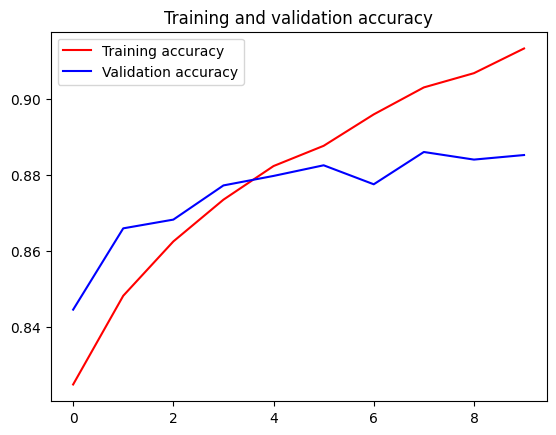

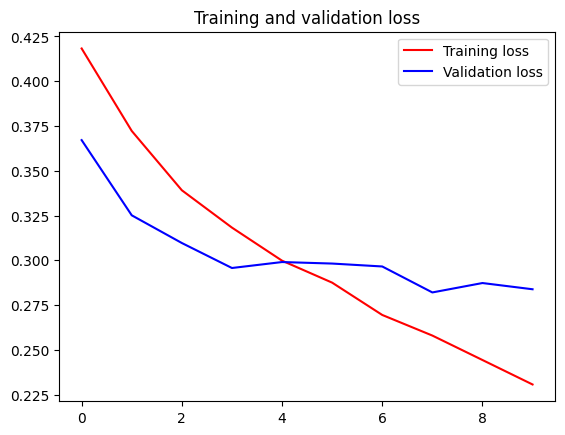

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [40]:
print('Training Accuracy: {}'.format(max(acc)))
print('Validation Accuracy: {}'.format(max(val_acc)))

Training Accuracy: 0.913349986076355
Validation Accuracy: 0.8860999941825867


In [42]:
import pickle
from tensorflow.keras.models import load_model

# Save the model
model.save('sentiment_model.h5')

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load the model
loaded_model = tf.keras.models.load_model('sentiment_model.h5')

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

In [44]:
def predict_sentiment(sentence):
    # Tokenize and pad the input sentence
    max_length = 200
    sequence = loaded_tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Make the prediction
    prediction = loaded_model.predict(padded_sequence)
    print(prediction[0][0])
    # Interpret the prediction
    if prediction[0][0] > 0.5:
        return "Positive"
    else:
        return "Negative"

# Example usage
sentence_to_predict = "worst bad"
result = predict_sentiment(sentence_to_predict)
print(f"The sentiment is: {result}")

1/1 [==============================] - 0s 55ms/step
0.28612784
The sentiment is: Negative


# Conclusion

1 - We have great accuracy and we can increase it training for much longer and tune other hyperparameters
2 - DNN LSTM have a deep impact on NLP problems and we can see that this model performs quite well.